In [41]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


In [42]:
# name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
name = "cic_ton_iot"
# name = "cic_ids_2017"
# name = "nf_bot_iot"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"

dataset = datasets[name]

In [43]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}

    
results_final["e_gcn"] = {}
results_final["e_gcn_res"] = {}

results_final["e_graph_sage"] = {}
results_final["e_graph_sage_res"] = {}

results_final["e_gat"] = {}
results_final["e_gat_res"] = {}


results_final

{'name': 'cic_ton_iot',
 'configuration': {'num_epochs': 100, 'batch_size': 128},
 'accuracy': {},
 'e_gcn': {},
 'e_gcn_res': {},
 'e_graph_sage': {},
 'e_graph_sage_res': {},
 'e_gat': {},
 'e_gat_res': {}}

In [44]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20240922-001531'

In [45]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)
    
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [46]:
with open("datasets/" + name + "/training_graph.pkl", "rb") as f:
    G = pickle.load(f)

In [47]:
G = from_networkx(G,edge_attrs=['h',dataset.label_col] )

In [48]:
num_features = G.edata['h'].shape[1]
num_features

38

In [49]:
G.ndata['h'] = th.ones(G.num_nodes(), num_features)

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, num_features))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [50]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(G.edata[dataset.label_col].cpu().numpy()),
                                                 y = G.edata[dataset.label_col].cpu().numpy())

In [51]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight = class_weights)

In [52]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [53]:
def train_gnn(model_class, Graph, residual, num_neighbors = None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if num_neighbors:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, num_neighbors=num_neighbors, residual=residual)
    else:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, residual=residual)

    opt = th.optim.Adam(model.parameters())

    for epoch in range(1,num_epochs):
    #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features,edge_features)
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

    return model

### Training EGCN

In [54]:
model_gcn = train_gnn(EGCN, G, False, None)

Epoch: 1  Training acc: 0.48081275820732117
Epoch: 2  Training acc: 0.8689320087432861
Epoch: 3  Training acc: 0.8305495977401733
Epoch: 4  Training acc: 0.9099267721176147
Epoch: 5  Training acc: 0.9537155628204346
Epoch: 6  Training acc: 0.9557409882545471
Epoch: 7  Training acc: 0.9758175611495972
Epoch: 8  Training acc: 0.9554134011268616
Epoch: 9  Training acc: 0.976084291934967
Epoch: 10  Training acc: 0.9560691118240356
Epoch: 11  Training acc: 0.9743859767913818
Epoch: 12  Training acc: 0.9760496020317078
Epoch: 13  Training acc: 0.9751183390617371
Epoch: 14  Training acc: 0.9764415621757507
Epoch: 15  Training acc: 0.9766653180122375
Epoch: 16  Training acc: 0.976689875125885
Epoch: 17  Training acc: 0.9760180711746216
Epoch: 18  Training acc: 0.9765899777412415
Epoch: 19  Training acc: 0.9765603542327881
Epoch: 20  Training acc: 0.9765854477882385
Epoch: 21  Training acc: 0.9768017530441284
Epoch: 22  Training acc: 0.9770703315734863
Epoch: 23  Training acc: 0.977393388748169

### Training EGCN residual

In [55]:
model_gcn_res = train_gnn(EGCN, G, True, None)

Epoch: 1  Training acc: 0.3840171694755554
Epoch: 2  Training acc: 0.5879079103469849
Epoch: 3  Training acc: 0.6180325150489807
Epoch: 4  Training acc: 0.7443437576293945
Epoch: 5  Training acc: 0.8138685822486877
Epoch: 6  Training acc: 0.851125955581665
Epoch: 7  Training acc: 0.9161744117736816
Epoch: 8  Training acc: 0.9334398508071899
Epoch: 9  Training acc: 0.9569905400276184
Epoch: 10  Training acc: 0.9585668444633484
Epoch: 11  Training acc: 0.9705431461334229
Epoch: 12  Training acc: 0.9705182909965515
Epoch: 13  Training acc: 0.9739804267883301
Epoch: 14  Training acc: 0.9743563532829285
Epoch: 15  Training acc: 0.974641740322113
Epoch: 16  Training acc: 0.9729097485542297
Epoch: 17  Training acc: 0.9751180410385132
Epoch: 18  Training acc: 0.9762354493141174
Epoch: 19  Training acc: 0.9763230085372925
Epoch: 20  Training acc: 0.9787227511405945
Epoch: 21  Training acc: 0.9776900410652161
Epoch: 22  Training acc: 0.9786453247070312
Epoch: 23  Training acc: 0.980492115020752


### Training EGraphSage 

In [56]:
model_sage = train_gnn(EGRAPHSAGE, G, False, 4)

Epoch: 1  Training acc: 0.5395203828811646
Epoch: 2  Training acc: 0.8532360196113586
Epoch: 3  Training acc: 0.9196797609329224
Epoch: 4  Training acc: 0.9552852511405945
Epoch: 5  Training acc: 0.9418391585350037
Epoch: 6  Training acc: 0.9742268323898315
Epoch: 7  Training acc: 0.9723690748214722
Epoch: 8  Training acc: 0.9764639735221863
Epoch: 9  Training acc: 0.9752742648124695
Epoch: 10  Training acc: 0.9532483220100403
Epoch: 11  Training acc: 0.9729685187339783
Epoch: 12  Training acc: 0.9739326238632202
Epoch: 13  Training acc: 0.9613355994224548
Epoch: 14  Training acc: 0.9736597537994385
Epoch: 15  Training acc: 0.9724534749984741
Epoch: 16  Training acc: 0.9553664326667786
Epoch: 17  Training acc: 0.9766391515731812
Epoch: 18  Training acc: 0.9748710989952087
Epoch: 19  Training acc: 0.975910484790802
Epoch: 20  Training acc: 0.9803797006607056
Epoch: 21  Training acc: 0.9761876463890076
Epoch: 22  Training acc: 0.9744396209716797
Epoch: 23  Training acc: 0.976472496986389

### Training EGraphSage residual

In [57]:
model_sage_res = train_gnn(EGRAPHSAGE, G, True, 4)

Epoch: 1  Training acc: 0.5567972660064697
Epoch: 2  Training acc: 0.8324110507965088
Epoch: 3  Training acc: 0.9107117056846619
Epoch: 4  Training acc: 0.935443103313446
Epoch: 5  Training acc: 0.9345238208770752
Epoch: 6  Training acc: 0.9525680541992188
Epoch: 7  Training acc: 0.9557279348373413
Epoch: 8  Training acc: 0.9571579098701477
Epoch: 9  Training acc: 0.967178225517273
Epoch: 10  Training acc: 0.9575827121734619
Epoch: 11  Training acc: 0.9765819907188416
Epoch: 12  Training acc: 0.9784541726112366
Epoch: 13  Training acc: 0.9765141606330872
Epoch: 14  Training acc: 0.9753241539001465
Epoch: 15  Training acc: 0.9586322903633118
Epoch: 16  Training acc: 0.9754469990730286
Epoch: 17  Training acc: 0.9779057502746582
Epoch: 18  Training acc: 0.9764922857284546
Epoch: 19  Training acc: 0.9752662181854248
Epoch: 20  Training acc: 0.9760341048240662
Epoch: 21  Training acc: 0.974899411201477
Epoch: 22  Training acc: 0.9774590730667114
Epoch: 23  Training acc: 0.9768815636634827


### Training EGAT

In [58]:
model_gat = train_gnn(EGAT, G, False, None)

Epoch: 1  Training acc: 0.5314144492149353
Epoch: 2  Training acc: 0.5900123715400696
Epoch: 3  Training acc: 0.8415774703025818
Epoch: 4  Training acc: 0.9499894380569458
Epoch: 5  Training acc: 0.951428234577179
Epoch: 6  Training acc: 0.9524478912353516
Epoch: 7  Training acc: 0.9549403190612793
Epoch: 8  Training acc: 0.9564101099967957
Epoch: 9  Training acc: 0.9566952586174011
Epoch: 10  Training acc: 0.9571141600608826
Epoch: 11  Training acc: 0.9572471380233765
Epoch: 12  Training acc: 0.9762674570083618
Epoch: 13  Training acc: 0.9763547778129578
Epoch: 14  Training acc: 0.9764503836631775
Epoch: 15  Training acc: 0.9764991998672485
Epoch: 16  Training acc: 0.9765074849128723
Epoch: 17  Training acc: 0.9765269756317139
Epoch: 18  Training acc: 0.9765109419822693
Epoch: 19  Training acc: 0.9767485857009888
Epoch: 20  Training acc: 0.9771365523338318
Epoch: 21  Training acc: 0.9773349165916443
Epoch: 22  Training acc: 0.9773939251899719
Epoch: 23  Training acc: 0.981364369392395

### Training EGAT residual

In [59]:
model_gat_res = train_gnn(EGAT, G, True, None)

Epoch: 1  Training acc: 0.5568728446960449
Epoch: 2  Training acc: 0.8330528736114502
Epoch: 3  Training acc: 0.9181686043739319
Epoch: 4  Training acc: 0.9580838680267334
Epoch: 5  Training acc: 0.9626120924949646
Epoch: 6  Training acc: 0.9640693068504333
Epoch: 7  Training acc: 0.9648734927177429
Epoch: 8  Training acc: 0.9642690420150757
Epoch: 9  Training acc: 0.9730250835418701
Epoch: 10  Training acc: 0.9736624360084534
Epoch: 11  Training acc: 0.9743237495422363
Epoch: 12  Training acc: 0.9750203490257263
Epoch: 13  Training acc: 0.9760113954544067
Epoch: 14  Training acc: 0.9766420722007751
Epoch: 15  Training acc: 0.9771338701248169
Epoch: 16  Training acc: 0.9774870872497559
Epoch: 17  Training acc: 0.9781158566474915
Epoch: 18  Training acc: 0.9785574674606323
Epoch: 19  Training acc: 0.9793261289596558
Epoch: 20  Training acc: 0.9802870750427246
Epoch: 21  Training acc: 0.9808810949325562
Epoch: 22  Training acc: 0.9813187122344971
Epoch: 23  Training acc: 0.98150962591171

# Testing

In [60]:
with open("datasets/" + name + "/testing_graph.pkl", "rb") as f:
    G_test = pickle.load(f)

In [61]:
G_test = from_networkx(G_test,edge_attrs=['h',dataset.label_col] )

In [62]:
actual_label = G_test.edata.pop(dataset.label_col)
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),num_features)

In [63]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [64]:
def test_gnn(model, graph):
    start_time = timeit.default_timer()
    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred)


In [65]:

def calculate_FPR_FNR(cm):
 
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
 
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
 
    return FPR, FNR

In [66]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path = None):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [67]:
actual, test_pred = test_gnn(model_gcn, G_test)

2.0331317987293005 seconds


In [68]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

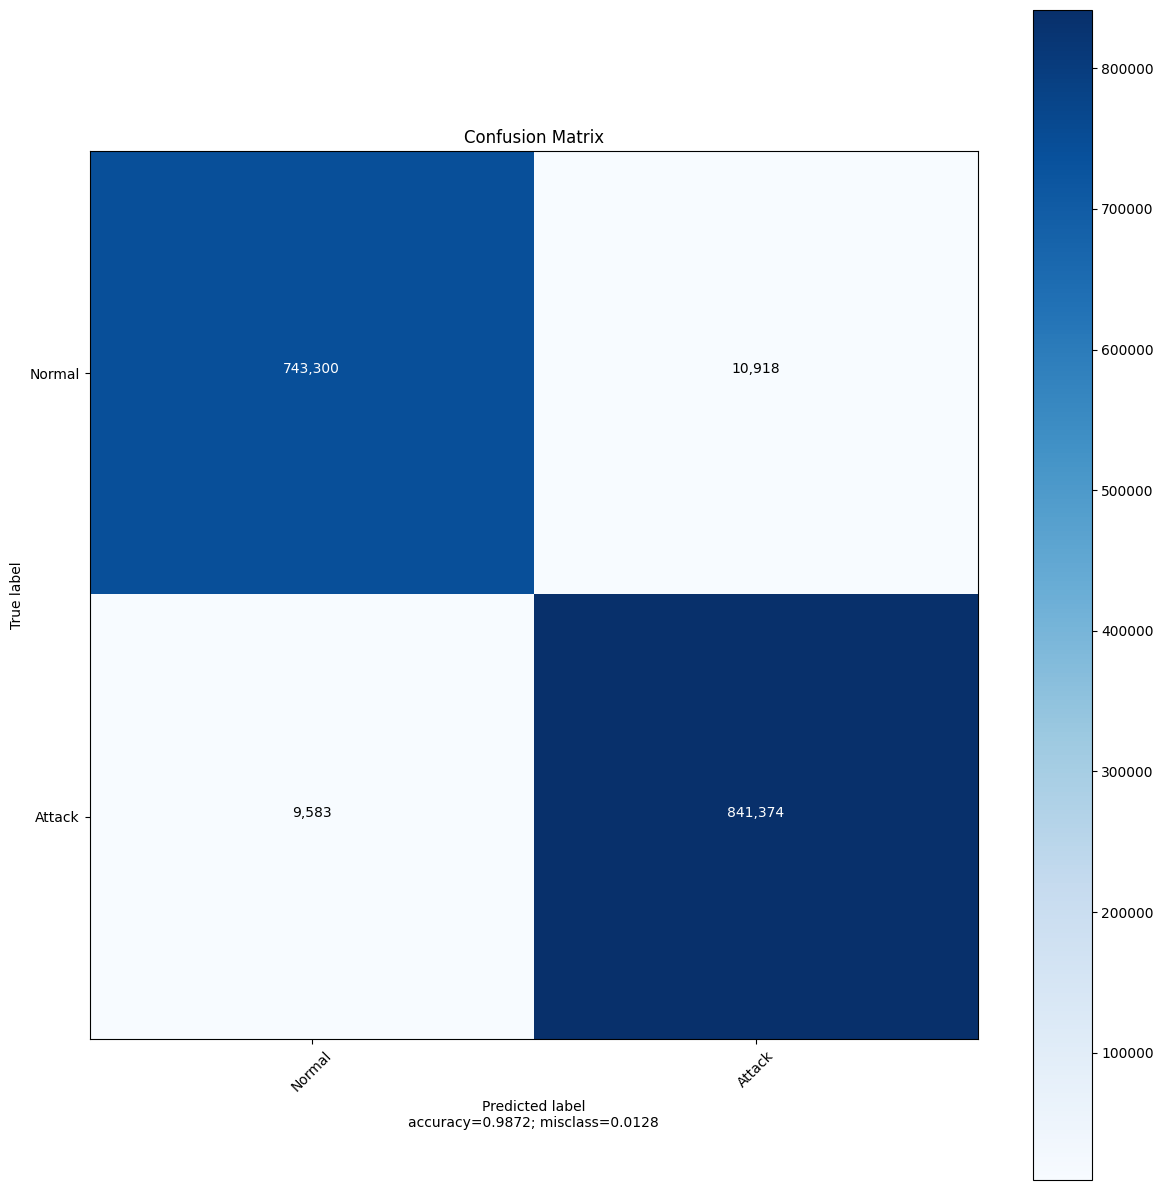

In [69]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn.png')

In [70]:
FPR, FNR = calculate_FPR_FNR(cm)

In [71]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn"]["classification_report"] = cr
results_final["e_gcn"]["FPR"] = FPR
results_final["e_gcn"]["FNR"] = FNR
results_final["accuracy"]["e_gcn"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9872    0.9887    0.9880    850957
      Normal     0.9873    0.9855    0.9864    754218

    accuracy                         0.9872   1605175
   macro avg     0.9872    0.9871    0.9872   1605175
weighted avg     0.9872    0.9872    0.9872   1605175



### Testing EGCN residual

In [72]:
actual, test_pred = test_gnn(model_gcn_res, G_test)

1.9745237994939089 seconds


In [73]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

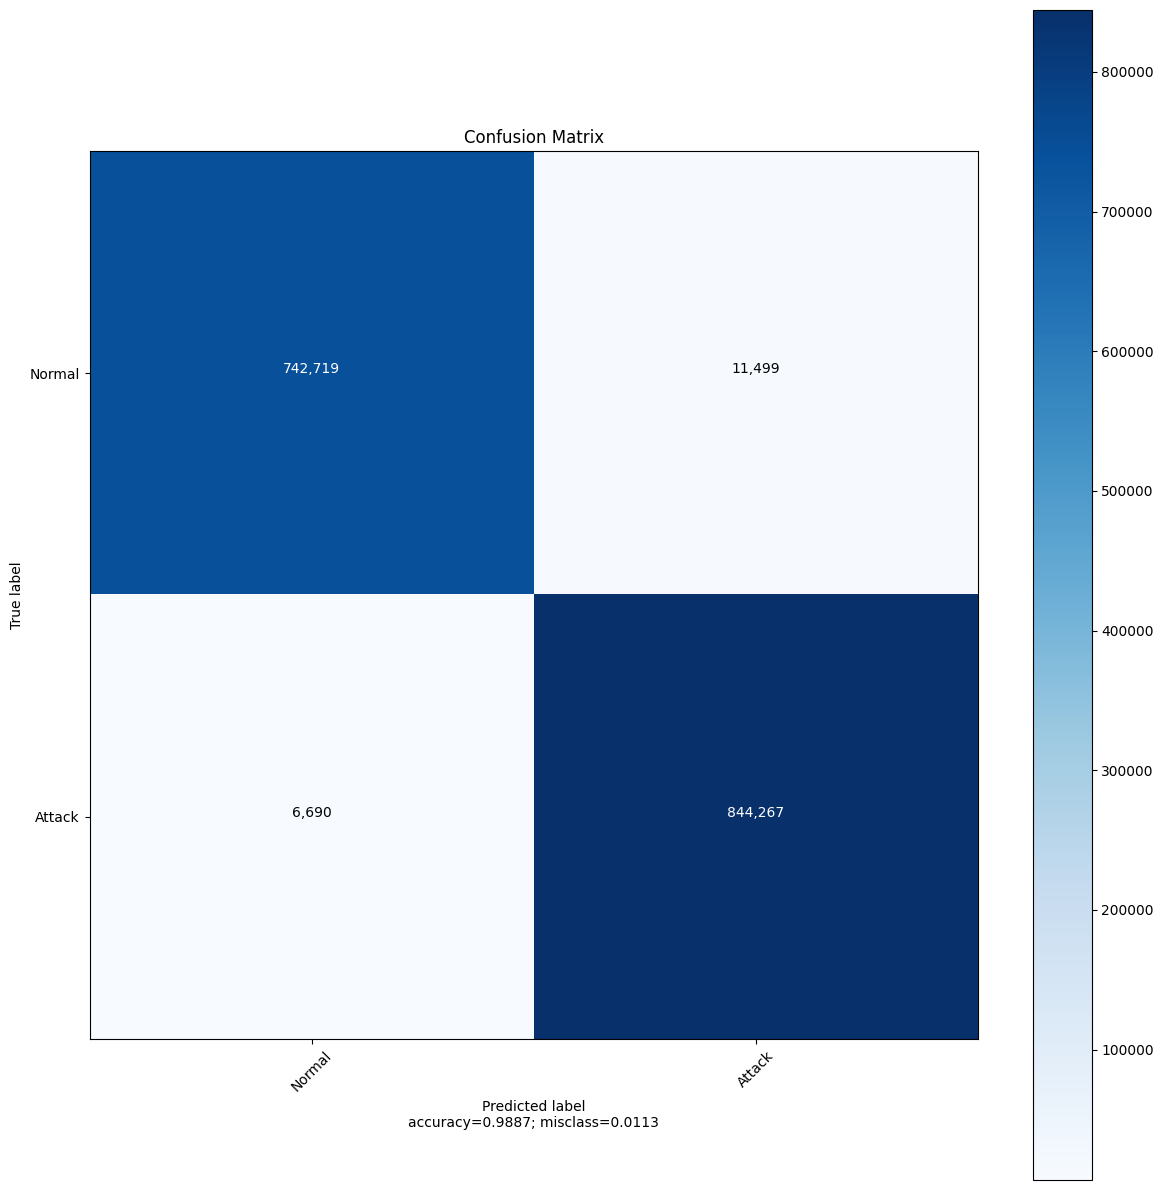

In [74]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn_res.png')

In [75]:
FPR, FNR = calculate_FPR_FNR(cm)

In [76]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn_res"]["classification_report"] = cr
results_final["e_gcn_res"]["FPR"] = FPR
results_final["e_gcn_res"]["FNR"] = FNR
results_final["accuracy"]["e_gcn_res"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9866    0.9921    0.9893    850957
      Normal     0.9911    0.9848    0.9879    754218

    accuracy                         0.9887   1605175
   macro avg     0.9888    0.9884    0.9886   1605175
weighted avg     0.9887    0.9887    0.9887   1605175



### Testing EGraphSage

In [77]:
actual, test_pred = test_gnn(model_sage, G_test)

0.8585192002356052 seconds


In [78]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

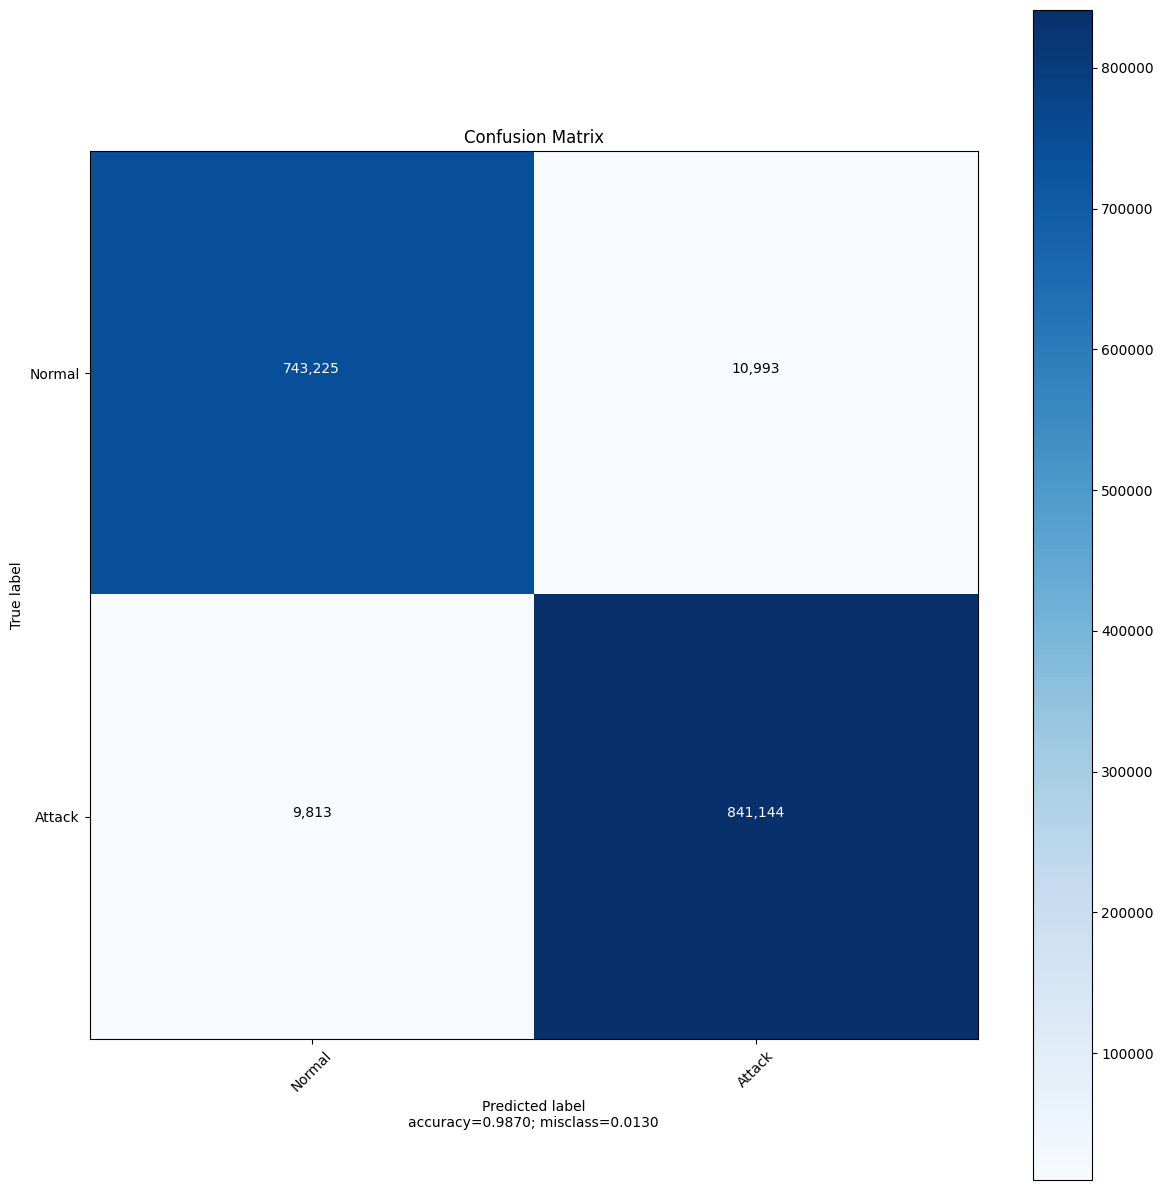

In [79]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage.png')

In [80]:
FPR, FNR = calculate_FPR_FNR(cm)

In [81]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage"]["classification_report"] = cr
results_final["e_graph_sage"]["FPR"] = FPR
results_final["e_graph_sage"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9871    0.9885    0.9878    850957
      Normal     0.9870    0.9854    0.9862    754218

    accuracy                         0.9870   1605175
   macro avg     0.9870    0.9869    0.9870   1605175
weighted avg     0.9870    0.9870    0.9870   1605175



### Testing EGraphSage residual

In [82]:
actual, test_pred = test_gnn(model_sage_res, G_test)

0.7517932988703251 seconds


In [83]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

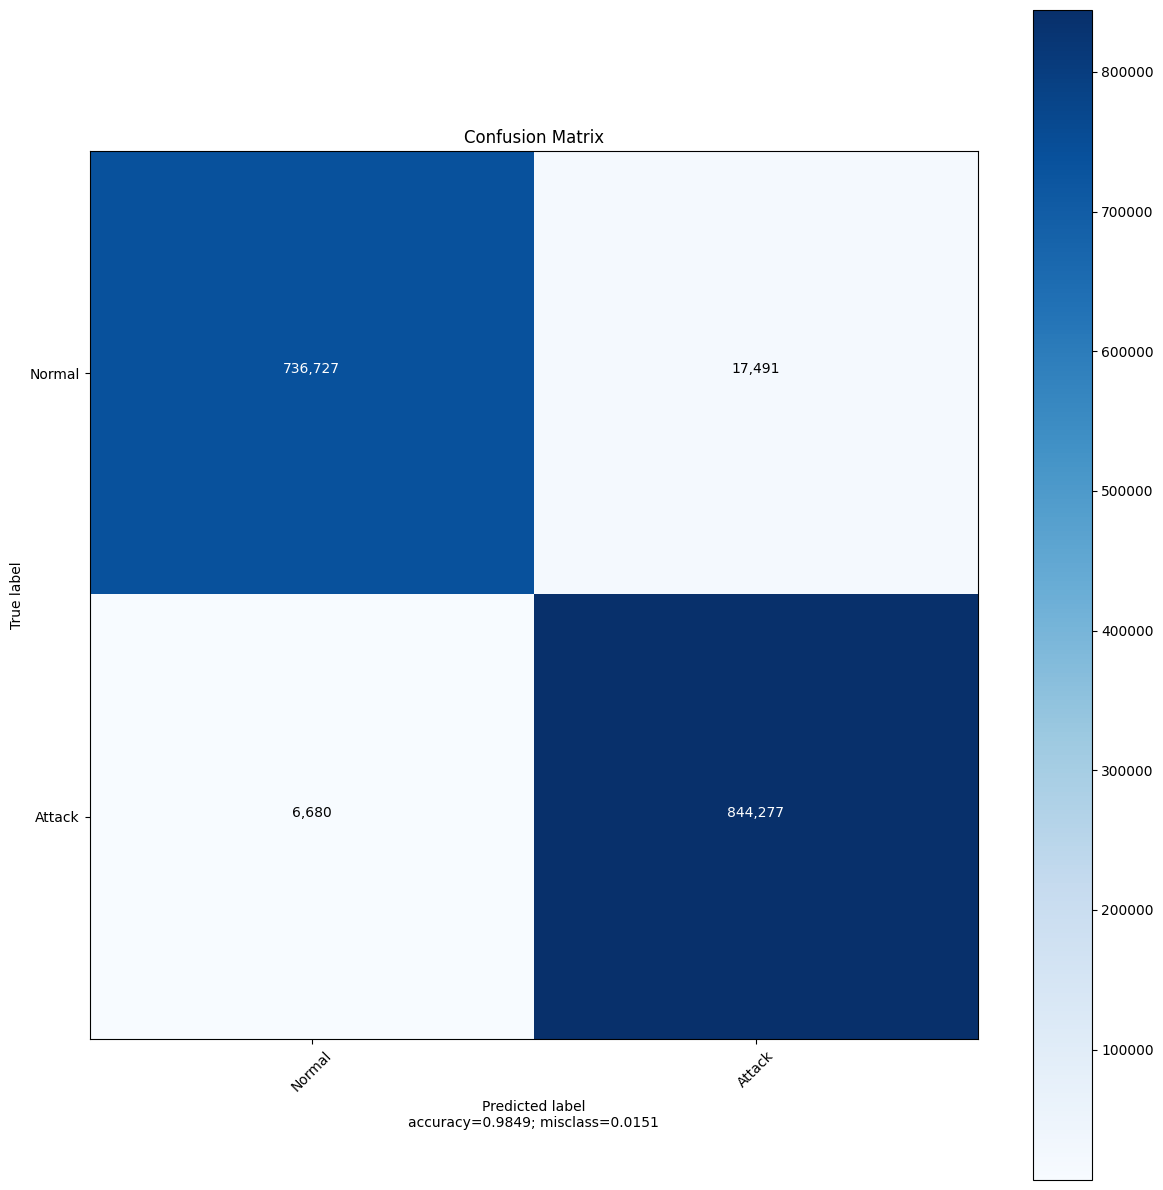

In [84]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage_res.png')

In [85]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage_res"]["classification_report"] = cr
results_final["e_graph_sage_res"]["FPR"] = FPR
results_final["e_graph_sage_res"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage_res"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9797    0.9922    0.9859    850957
      Normal     0.9910    0.9768    0.9839    754218

    accuracy                         0.9849   1605175
   macro avg     0.9854    0.9845    0.9849   1605175
weighted avg     0.9850    0.9849    0.9849   1605175



### Testing EGAT

In [86]:
actual, test_pred = test_gnn(model_gat, G_test)

6.289755899459124 seconds


In [87]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

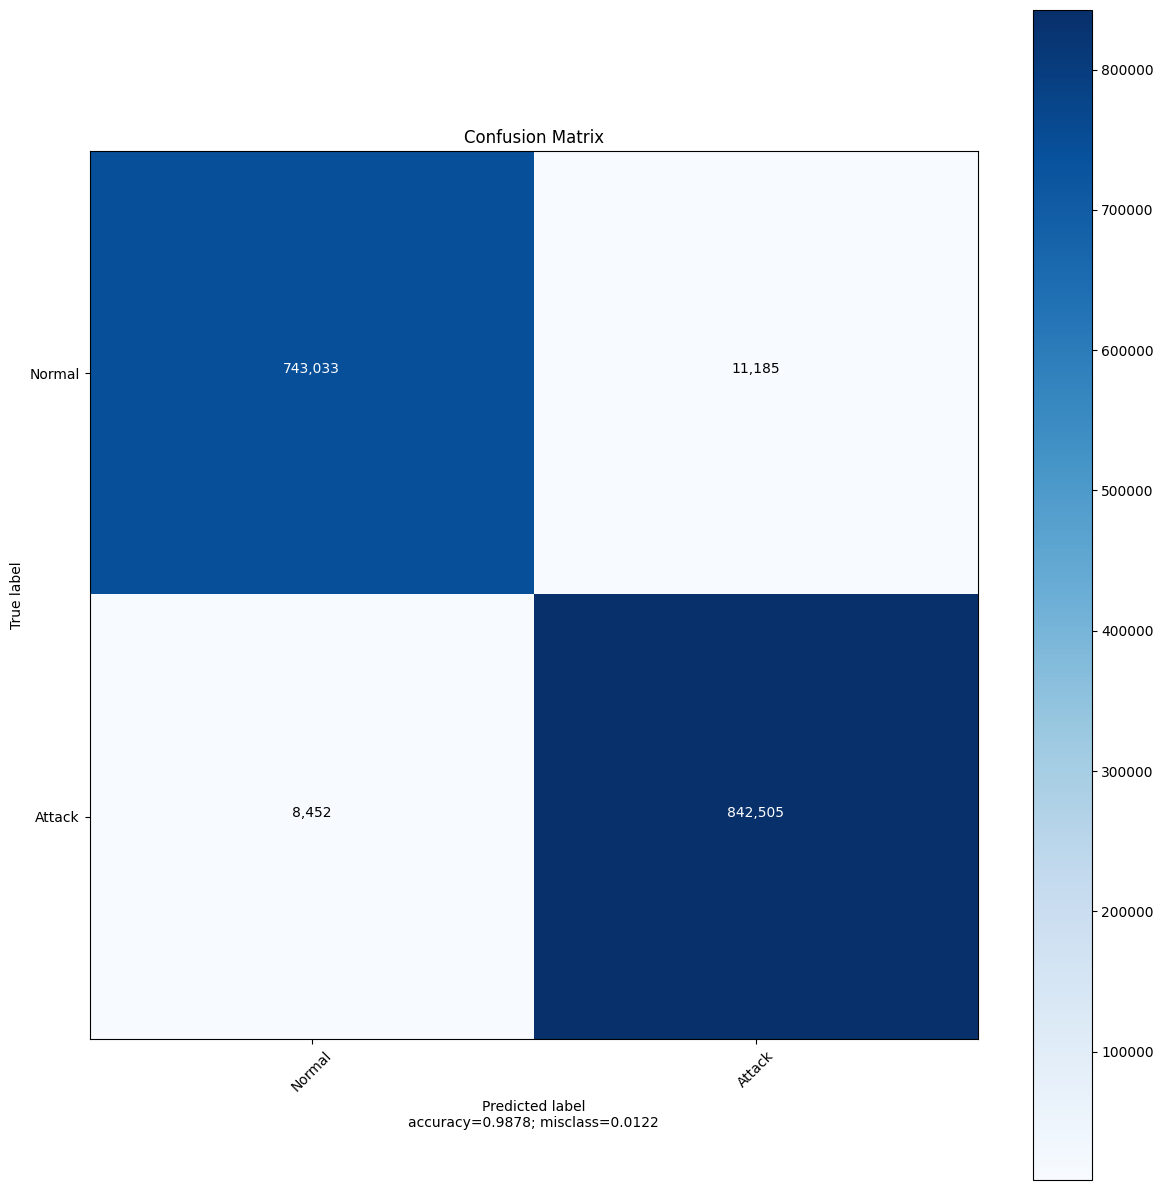

In [88]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat.png')

In [89]:
FPR, FNR = calculate_FPR_FNR(cm)

In [90]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat"]["classification_report"] = cr
results_final["e_gat"]["FPR"] = FPR
results_final["e_gat"]["FNR"] = FNR
results_final["accuracy"]["e_gat"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9869    0.9901    0.9885    850957
      Normal     0.9888    0.9852    0.9870    754218

    accuracy                         0.9878   1605175
   macro avg     0.9878    0.9876    0.9877   1605175
weighted avg     0.9878    0.9878    0.9878   1605175



### Testing EGAT residual

In [91]:
actual, test_pred = test_gnn(model_gat_res, G_test)

6.479380698874593 seconds


In [92]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

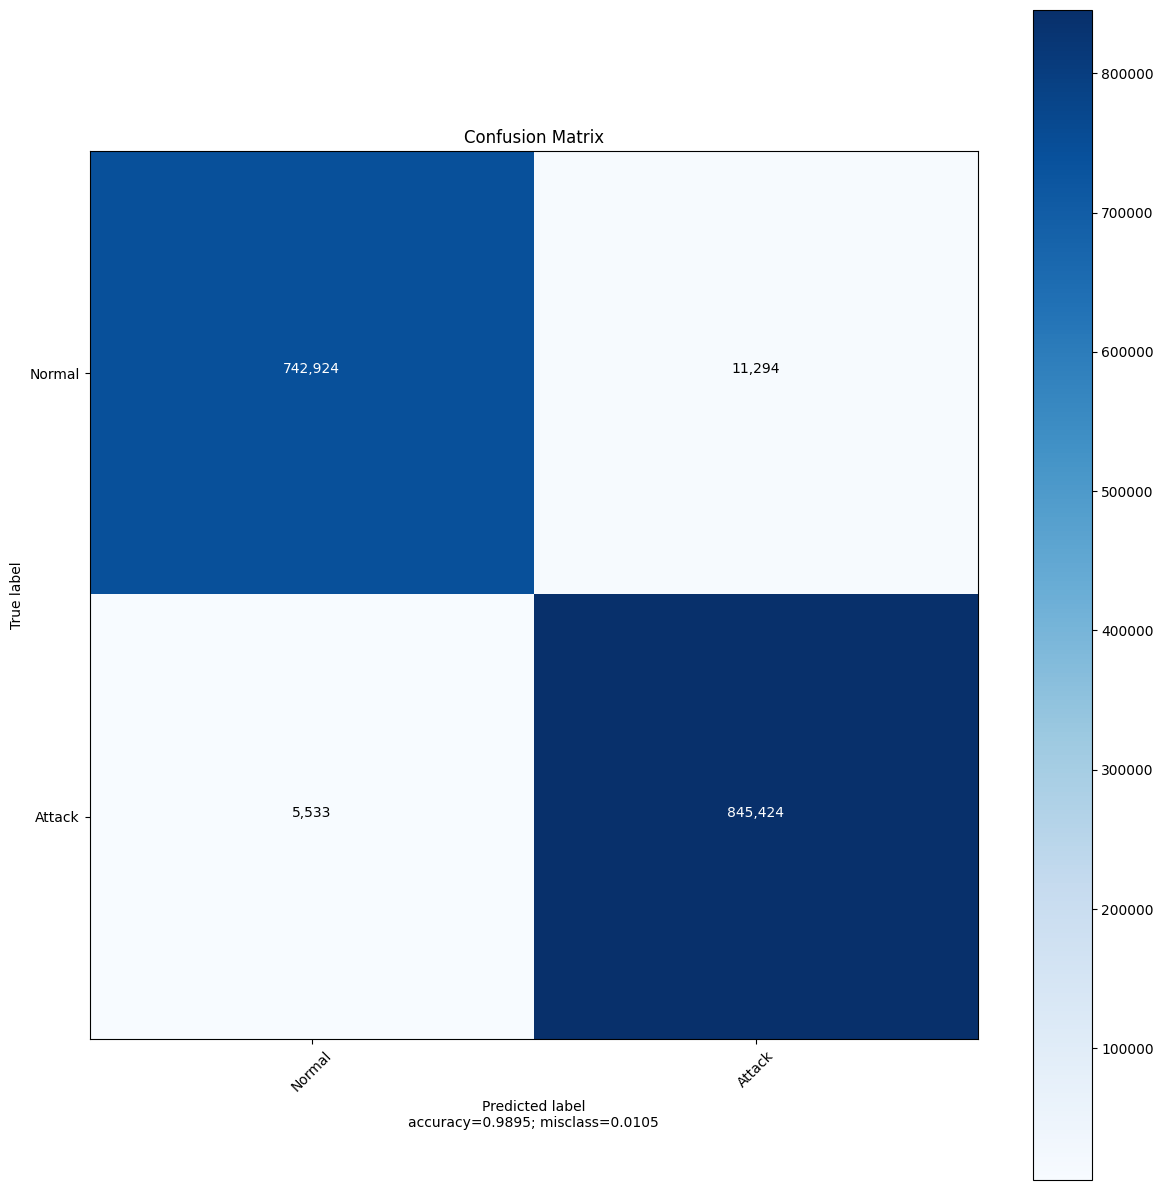

In [93]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat_res.png')

In [94]:
FPR, FNR = calculate_FPR_FNR(cm)

In [95]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat_res"]["classification_report"] = cr
results_final["e_gat_res"]["FPR"] = FPR
results_final["e_gat_res"]["FNR"] = FNR
results_final["accuracy"]["e_gat_res"] = cr["accuracy"]

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9868    0.9935    0.9901    850957
      Normal     0.9926    0.9850    0.9888    754218

    accuracy                         0.9895   1605175
   macro avg     0.9897    0.9893    0.9895   1605175
weighted avg     0.9895    0.9895    0.9895   1605175



### Saving results

In [96]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()